In [2]:
import sys
from zmq import device
print(sys.executable)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
from scipy.stats import norm
from utils import *
from pinn import PINNs

/data/vinay_2421ma05/VINAY/BS_PF/.conda/bin/python


In [3]:
# BS params
K = 4
sigma = 0.3
r = 0.03
T = 1
L = 10
N_x = 101
N_t = 101
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
res, b_left, b_right, b_upper, b_lower = get_data([0,10], [0, 1], N_x, N_t)
res_test, _, _, _, _ = get_data([0,10], [0,1], N_x, N_t)
# print(res.shape, b_left.shape, b_right.shape, b_upper.shape, b_lower.shape)
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

print(x_res.shape, x_left.shape, x_right.shape, x_upper.shape, x_lower.shape)
print(t_res.shape, t_left.shape, t_right.shape, t_upper.shape, t_lower.shape)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])


In [5]:
pinn = PINNs(in_dim=2, hidden_dim=32, out_dim=1, num_layer=4).to(device)
pinn.apply(init_weights)
optim = LBFGS(pinn.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters(), lr=1e-4)
n_params = get_n_params(pinn)
print(pinn)
print('No of Parameters',n_params)

/tmp/ipykernel_90130/2410366736.py:20: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
No of Parameters 2241


In [6]:
kernel_size = 200
D1 = kernel_size
D2 = len(x_left)
D3 = len(x_lower)
def compute_ntk(J1, J2):
    Ker = torch.matmul(J1, torch.transpose(J2, 0, 1))
    return Ker

In [7]:
print(D1)
print(D2)
print(D3)

200
101
101


In [7]:
loss_track = []
w1, w2, w3 = 1, 1, 1
n_epochs = 500
for i in tqdm(range(n_epochs)):
    if i % 50 == 0:
        J1 = torch.zeros((D1, n_params))
        J2 = torch.zeros((D2, n_params))
        J3 = torch.zeros((D3, n_params))

        batch_ind = np.random.choice(len(x_res), kernel_size, replace=False)
        x_train, t_train = x_res[batch_ind], t_res[batch_ind]

        pred_res = pinn(x_train, t_train)
        pred_left = pinn(x_left, t_left)
        pred_right = pinn(x_right, t_right)
        pred_upper = pinn(x_upper, t_upper)
        pred_lower = pinn(x_lower, t_lower)

        for j in range(len(x_train)):
            pinn.zero_grad()
            pred_res[j].backward(retain_graph=True)
            J1[j, :] = torch.cat([p.grad.view(-1) for p in pinn.parameters()])
        for j in range(len(x_left)):
            pinn.zero_grad()
            pred_left[j].backward(retain_graph=True)
            J2[j, :] = torch.cat([p.grad.view(-1) for p in pinn.parameters()])
        for j in range(len(x_lower)):
            pinn.zero_grad()
            pred_lower[j].backward(retain_graph=True)
            pred_upper[j].backward(retain_graph=True)
            J3[j, :] = torch.cat([p.grad.view(-1) for p in pinn.parameters()])
        K1 = torch.trace(compute_ntk(J1, J1))
        K2 = torch.trace(compute_ntk(J2, J2))
        K3 = torch.trace(compute_ntk(J3, J3))
        print(f'K1: {K1.item():.4f}, K2: {K2.item():.4f}, K3: {K3.item():.4f}')

        #K = K1+K2+K3
        #w1 = K.item() / (K1.item())
        #w2 = K.item() / (K2.item())
        #w3 = K.item() / (K3.item())

        w1 = 1 / K1.item()
        w2 = 1 / K2.item()
        w3 = 1 / K3.item()

        total = w1 + w2 + w3

        w1 = w1/total
        w2 = w2/total
        w3 = w3/total
        print(f'Weights: w1: {w1:.4f}, w2: {w2:.4f}, w3: {w3:.4f}')
    def closure():
        pred_res = pinn(x_res, t_res)
        pred_left = pinn(x_left, t_left)
        pred_right = pinn(x_right, t_right)
        pred_upper = pinn(x_upper, t_upper)
        pred_lower = pinn(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t - ((sigma**2 * x_res**2) / 2) * u_xx - (r * x_res) * u_x + (r * pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower - (K * torch.exp(-r * t_lower))) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.max(K - x_left[:,0], torch.zeros(x_left[:,0].shape).to(device))) ** 2)

        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
        loss = w1*loss_res + w2*loss_ic + w3*loss_bc
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)
if i % 100 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {loss_track[-1][0]:.9f}, BVP Loss: {loss_track[-1][1]:.9f}, IC Loss: {loss_track[-1][2]:.9f},')

print('Loss Res: {:9f}, Loss_BC: {:9f}, Loss_IC: {:9f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

  0%|          | 0/500 [00:00<?, ?it/s]

K1: 6889.1704, K2: 3446.9497, K3: 6345.7500
Weights: w1: 0.2448, w2: 0.4893, w3: 0.2658


 10%|█         | 50/500 [00:17<02:27,  3.04it/s]

K1: 23751.2109, K2: 10715.5576, K3: 14768.5146
Weights: w1: 0.2073, w2: 0.4594, w3: 0.3333


 20%|██        | 100/500 [00:33<01:59,  3.34it/s]

K1: 41503.2070, K2: 14185.4785, K3: 15992.3408
Weights: w1: 0.1534, w2: 0.4487, w3: 0.3980


 31%|███       | 156/500 [00:40<00:15, 22.19it/s]

K1: 48248.9414, K2: 15511.7314, K3: 16772.7539
Weights: w1: 0.1431, w2: 0.4452, w3: 0.4117


 40%|███▉      | 198/500 [00:40<00:05, 53.70it/s]

K1: 45377.4727, K2: 15504.2188, K3: 16782.4473
Weights: w1: 0.1508, w2: 0.4414, w3: 0.4078


 50%|█████     | 250/500 [00:43<00:05, 41.82it/s]

K1: 50151.1875, K2: 15630.1309, K3: 16801.9746
Weights: w1: 0.1390, w2: 0.4460, w3: 0.4149


 62%|██████▏   | 308/500 [00:53<00:13, 14.02it/s]

K1: 51177.7617, K2: 17392.2324, K3: 19448.3086
Weights: w1: 0.1521, w2: 0.4476, w3: 0.4003


 71%|███████   | 356/500 [00:54<00:06, 21.47it/s]

K1: 53915.2617, K2: 17388.9922, K3: 19423.2891
Weights: w1: 0.1454, w2: 0.4509, w3: 0.4037


 81%|████████  | 405/500 [00:55<00:04, 23.05it/s]

K1: 57943.9688, K2: 17379.7402, K3: 19412.4727
Weights: w1: 0.1366, w2: 0.4555, w3: 0.4078


 92%|█████████▏| 461/500 [00:57<00:01, 29.62it/s]

K1: 60205.9688, K2: 17390.8848, K3: 19458.7090
Weights: w1: 0.1323, w2: 0.4582, w3: 0.4095


100%|██████████| 500/500 [00:57<00:00,  8.63it/s]

Loss Res:  0.000040, Loss_BC:  0.000020, Loss_IC:  0.000000
Train Loss: 0.000061


In [8]:
print(J1)

tensor([[-4.0321e-02, -1.1060e-02,  1.0188e-01,  ..., -6.3753e-01,
         -7.1550e-01,  1.0000e+00],
        [-6.3814e-02, -9.8175e-03, -1.8007e-02,  ..., -4.2012e-01,
         -9.0329e-01,  1.0000e+00],
        [-1.0247e-03, -5.4504e-06,  2.4390e-03,  ..., -8.1237e-01,
         -5.5533e-01,  1.0000e+00],
        ...,
        [-8.8264e-02, -1.3681e-02,  1.5559e-01,  ..., -6.3619e-01,
         -6.8087e-01,  1.0000e+00],
        [-6.4064e-02, -1.1669e-02,  1.3966e-01,  ..., -6.2496e-01,
         -7.0241e-01,  1.0000e+00],
        [-9.8922e-03, -3.8641e-04,  1.6774e-02,  ..., -7.5943e-01,
         -5.9861e-01,  1.0000e+00]])


In [9]:
print(K1,K2,K3)
print(pred_res)
print(pred_left)
print(pred_lower)
print(pred_upper)

tensor(60205.9688) tensor(17390.8848) tensor(19458.7090)
tensor([[ 6.5099e-01],
        [ 2.6748e+00],
        [-1.6600e-05],
        [ 3.2908e+00],
        [-2.6143e-04],
        [ 3.5143e-01],
        [ 1.8454e-02],
        [ 9.7725e-04],
        [-1.0470e-03],
        [ 3.8977e-01],
        [-8.4990e-04],
        [-3.0312e-04],
        [ 2.6133e-01],
        [ 4.9008e-02],
        [ 1.6102e-02],
        [ 3.0919e+00],
        [ 1.5180e+00],
        [ 3.1270e+00],
        [-1.1197e-04],
        [ 3.4888e-02],
        [-6.8179e-04],
        [ 3.1670e-03],
        [ 3.0978e-02],
        [-5.1790e-04],
        [ 8.1452e-02],
        [ 8.3232e-02],
        [ 1.1791e-01],
        [ 1.0708e-02],
        [ 1.6024e-03],
        [-1.4368e-04],
        [-1.7402e-04],
        [ 1.5704e+00],
        [ 1.1928e-02],
        [ 4.8082e-01],
        [-2.5252e-04],
        [-8.7112e-05],
        [ 2.6554e+00],
        [-5.6899e-04],
        [ 8.3445e-01],
        [ 2.2820e-04],
        [ 1.1511e+00],


In [19]:
print(K)

tensor(361261.)


In [20]:
print(w1,w2,w3)

print(loss_track)

3.5210623781676413 6.972400748846814 1.7465046797648516
[[0.007895613089203835, 11793898496.0, 11448048640.0], [0.008102558553218842, 11793892352.0, 11448047616.0], [0.009101944044232368, 11793863680.0, 11448046592.0], [0.016506271436810493, 11793699840.0, 11448034304.0], [0.05061085522174835, 11793271808.0, 11448004608.0], [0.4358619451522827, 11791239168.0, 11447820288.0], [2.6747443675994873, 11785892864.0, 11445785600.0], [10.705251693725586, 11770436608.0, 11425274880.0], [310.7110290527344, 11667473408.0, 11323395072.0], [6554.98388671875, 11223051264.0, 10890772480.0], [1780099.875, 4112080384.0, 5887385600.0], [7625644.0, 475869312.0, 7929742848.0], [12782211.0, 111825848.0, 14351750144.0], [7982933.5, 207907792.0, 9034928128.0], [7095323.5, 392401728.0, 8215856128.0], [6865810.0, 451859680.0, 8015643136.0], [7839299.0, 469421856.0, 7949922304.0], [7057708.5, 474289664.0, 7934582784.0], [6948888.5, 475370080.0, 7931271680.0], [57818296.0, 681023424.0, 7394764800.0], [3538163456

In [10]:
print('NTK weight: w_res: {:4f} w_ic: {:4f}, w_bc: {:4f}'.format(w1, w2, w3))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))
torch.save(pinn.state_dict(), './1dwave_pinns_ntk.pt')

NTK weight: w_res: 0.132346 w_ic: 0.458171, w_bc: 0.409483
Train Loss: 0.000061


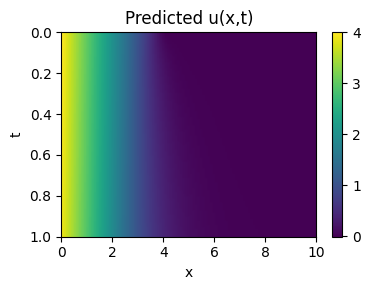

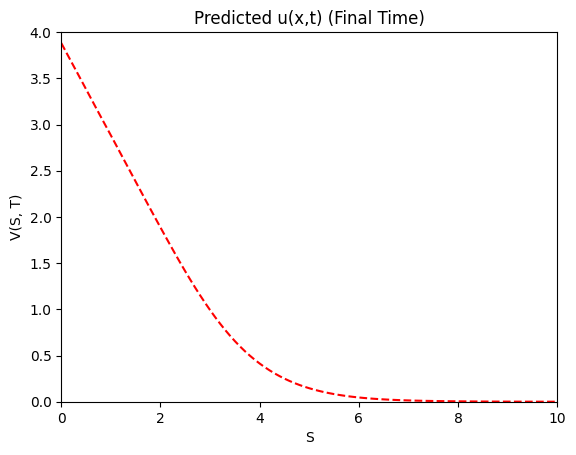

In [11]:
state = {
    'epoch': n_epochs,
    'state_dict': pinn.state_dict(),
    'optimizer': optim.state_dict(),
    'loss_hist': loss_track
}

torch.save(state, './BS_Put_PINNs_101')
# Testing
N_x=101
N_t=101
res_test, _, b_right_test, _, _ = get_test_data([0,10], [0,1], N_x, N_t)
# step_size = 1e-4

N = norm.cdf

# res_test = make_time_sequence(res_test, num_step=5, step=step_size)
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
b_right_test = torch.tensor(b_right_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]
x_right_test, t_right_test = b_right_test[:,0:1], b_right_test[:,1:2]

with torch.no_grad():
    pred = pinn(x_test, t_test)[:,0:1]
    pred_right = pinn(x_right_test, t_right_test)[:,0:1]
    pred = pred.cpu().detach().numpy()
    pred_right = pred_right.cpu().detach().numpy()
pred = pred.reshape(N_x,N_t)


plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,10,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dBS_Put_pinns_pred.png')



# plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")
plt.figure()
plt.plot(x_right_test.cpu().detach().numpy(), pred_right, '--', color="r")
plt.xlabel('S')
plt.ylabel('V(S, T)')
plt.title('Predicted u(x,t) (Final Time)')
# set the limits
plt.xlim([0, 10])
plt.ylim([0, 4])
plt.savefig('./1dBS_Put_pinns_pred(Final Time).png')

